##### This notebook uses a cell-centered grid approach to solving 2 cases of the Poisson Equation

In [1]:
from math import pi
import numpy
#
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot, cm
#%matplotlib notebook
%matplotlib inline
#
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
from IPython.core.display import HTML
#css_file = '/Users/Luis/numerical-mooc/styles/numericalmoocstyle.css'
css_file = './numericalmoocstyle.css'
HTML(open(css_file, "r").read())

In [3]:
import numba
from numba import jit

In [60]:
# Parameters
nx = [26, 51, 101, 151, 201]
ny = [26,51, 101, 151, 201]
#
nxc = [25,50,100,150, 200]
nyc = [25,50,100,150, 200]
#
#Domain Size
xmin = 0.
xmax = 1.
ymin = 0.
ymax = 1.
#L2 Target
l2_target = 1e-8
# Frequency values:
nf = [1.,2.,4.,8., 12.0]

In [5]:
def domain (numxg, numyg, x_min, x_max, y_min, y_max):
    #
    ngrid = numpy.size(numxg)
    # define sizes
    delxg = [] #spacing
    delyg = []
    #
    Xbg = []
    Ybg = []
    #
    Xcg = []
    Ycg = []
    #
#     Xbg = numpy.zeros_like(ngrid)
#     Ybg = numpy.zeros_like(ngrid)
#     #
#     Xcg = numpy.zeros_like(ngrid)
#     Ycg = numpy.zeros_like(ngrid)
    #
    xbg = []
    xcg = []
    #
    ybg = []
    ycg = []
    #
    for i in range(ngrid):
        #fill array of grid nodes
        nx_k = numxg[i]
        ny_k = numyg[i]
        #grid spacing
        delx_k = (x_max-x_min)/(nx_k-1)
        dely_k = (y_max-y_min)/(ny_k-1)
        #
        delxg.append(delx_k)
        delyg.append(dely_k)
        #
        xb_k = numpy.linspace(x_min, x_max, nx_k)
        yb_k = numpy.linspace(y_min, y_max, ny_k)
        #
        xc_k = xb_k[:-1]+(delx_k*.5)      
        yc_k = yb_k[:-1]+(dely_k*.5)  
        #
        xbg.append(xb_k)
        xcg.append(xc_k)
        #
        ybg.append(yb_k)
        ycg.append(yc_k)
        #
        Xb_k,Yb_k = numpy.meshgrid(xb_k,yb_k)
        Xc_k,Yc_k = numpy.meshgrid(xc_k,yc_k)
        #print(numpy.shape(Xb_k))
        #
        Xbg.append(Xb_k)
        Xcg.append(Xc_k)
        #
        Ybg.append(Yb_k)
        Ycg.append(Yc_k)
        #
    return xbg,ybg,xcg,ycg, Xbg, Ybg, Xcg, Ycg, delxg, delyg
        
    
    

In [6]:
xb,yb,xc,yc,Xb,Yb,Xc,Yc,dx,dy = domain (nx, nx, xmin, xmax, ymin, ymax)

In [7]:
def plot_3D(xp, yp, p_sol):
    '''This function creates 3D plot for solution

    Parameters:
    ----------
    xp: array of x grid points
    yp: array of y grid points
    p_sol: 2D array of calculated solution
    
    Returns:
    ----------
    3D plot of result
    '''
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    XP,YP = numpy.meshgrid(xp,yp)
    surf = ax.plot_surface(XP,YP,p_sol[:], rstride=1, cstride=1, cmap=cm.cool, linewidth=0, antialiased=False)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    ax.view_init(30,45)

In [8]:
def p_analytical(XP,YP, n_amp):
    '''This function calculates the analytical solution

    Parameters:
    ----------
    XP: 2D array of floats x-position of mesh
    YP: 2D array of floats y-position of mesh
    n_amp: Amplitude  
    
    Returns:
    ----------
    '''
    p_analytical = numpy.sin(2*pi*n_amp*XP)*numpy.sin(2*pi*n_amp*YP)
    #
    return p_analytical

In [9]:
def p_analytical2(XP,YP, n_amp):
    '''This function calculates the analytical solution

    Parameters:
    ----------
    XP: 2D array x-position of mesh
    YP: 2D array y-position of mesh
    n_amp: Amplitude  
    
    Returns:
    ----------
    '''
    p_analytical2 = numpy.cos(2*pi*n_amp*XP)*numpy.cos(2*pi*n_amp*YP)
    #
    return p_analytical2

In [10]:
def get_RHS(XP,YP,n_amp):
    '''This function solves the right hand side of the modeled solution

    Parameters:
    ----------
    XP: 2D array of floats x-position of mesh
    YP: 2D array of floats y-position of mesh
    n_amp: Amplitude  
    
    Returns:
    ----------
    '''
    f_rhs = -8*((pi*n_amp)**2)*numpy.sin(2*pi*n_amp*XP)*numpy.sin(2*pi*n_amp*YP)
    #
    return f_rhs

In [11]:
def get_RHS_2(XP,YP,n_amp):
    '''This function solves the right hand side of the modeled solution

    Parameters:
    ----------
    XP: 2D array of floats x-position of mesh
    YP: 2D array of floats y-position of mesh
    n_amp: Amplitude  
    
    Returns:
    ----------
    '''
    f_rhs2 = -8*((pi*n_amp)**2)*numpy.cos(2*pi*n_amp*XP)*numpy.cos(2*pi*n_amp*YP)
    #
    return f_rhs2

In [12]:
def init_poisson(numx, numy):
    '''This function initializes the flow field

    Parameters:
    ----------
    numx: number of x grid points
    numy: number of y grid points 
    
    Returns:
    ----------
    '''
    p_i  = numpy.random.rand(numx,numy)
    #p_i = numpy.zeros((numx, numy))
    return p_i

In [13]:
def L2_error(p_new, p_old):
    '''This function computes the L2 norm of the error for convergence

    Parameters:
    ----------
    p_new: new computed potential in flow field
    p_old: previous flow field potential
    
    Returns:
    ----------
    error!
    '''
    
    return numpy.sqrt(numpy.sum((p_new[:,:] - p_old[:,:])**2)/numpy.sum(p_old[:,:]**2))

In [14]:
def L2_error_2(p_new, p_old):
    '''This function computes the L2 norm of the error for convergence

    Parameters:
    ----------
    p_new: new computed potential in flow field
    p_old: previous flow field potential
    
    Returns:
    ----------
    error!
    '''
    
    return numpy.sqrt(numpy.sum((p_new[1:-1,1:-1] -\
                            p_old[1:-1,1:-1])**2)/numpy.sum(p_old[1:-1,1:-1]**2))

In [15]:
def plot_algb_conv(J_err, GS_err, SOR_err, string_title):
    #
    pyplot.figure(figsize=(8,5))
    pyplot.title(string_title)
    pyplot.xlabel(r'iterations', fontsize=18)
    pyplot.ylabel(r'$L_2$-norm', fontsize=18)
    pyplot.semilogy(numpy.trim_zeros(J_err,'b'),
                'b-', lw=2, label='Jacobi')
    pyplot.semilogy(numpy.trim_zeros(GS_err,'b'), 
                'k--', lw=2, label='Gauss-Seidel')
    pyplot.semilogy(numpy.trim_zeros(SOR_err,'b'), 
                'g-', lw=2, label='SOR')
    pyplot.legend(fontsize=16);

In [16]:
def plot_error_grid_refine(err1,nv, string_title):
    pyplot.figure(figsize=(8,8))
    
    pyplot.grid(True)
    pyplot.xlabel(r'$n_x$', fontsize=18)
    pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)
    pyplot.title(string_title)
    #
    pyplot.loglog(nv, err1, color='k', ls='--', lw=2, marker='o')
    pyplot.axis('equal');

## CASE 1 - HOMOGENEOUS DIRICHLET BCs

In [17]:
p_an_g1_w1 = p_analytical(Xc[0], Yc[0], nf[0])
p_init_g1 = init_poisson(nxc[0], nyc[0])
f_g1_w1 = get_RHS(Xc[0],Yc[0],nf[0])

In [18]:
# p_an_g2_w1 = p_analytical(Xc[1], Yc[1], nf[0])
# p_init_g2 = init_poisson(nxc[1], nyc[1])
# f_g2_w1 = get_RHS(Xc[1],Yc[1],nf[0])

In [19]:
# p_an_g3_w1 = p_analytical(Xc[2], Yc[2], nf[0])
# p_init_g3 = init_poisson(nxc[2], nyc[2])
# f_g3_w1 = get_RHS(Xc[2],Yc[2],nf[0])

In [20]:
# p_an_g4_w1 = p_analytical(Xc[3], Yc[3], nf[0])
# p_init_g4 = init_poisson(nxc[3], nyc[3])
# f_g4_w1 = get_RHS(Xc[3],Yc[3],nf[0])

### Jacobi Method

In [21]:
def jacobi_dirichlet(p, f, numx, numy, delx, dely, l2_target):
    ''' Function uses Jacobi iteration to solve 
        homogeneous dirichlet BCs
    
    Parameters:
    ----------
    p : 2D array initial guess
    f : 2D array source term
    delx: spacing in x direction
    dely: spacing in y direction
    l2_target: target difference consecutive iterations
    
    Returns:
    -------
    p: 2D array of float solution
    iterations: number of iterations to convergence
    l2_err: l2 norm of error
    '''
    l2_norm = 1.1 + l2_target #want to make sure this is high enough!
    iterations = 0
    l2_err = []
    
    while l2_norm > l2_target:
        #
        pk = p.copy()
        #
        p[1:-1,1:-1] = (1/(2*(delx**2 + dely**2))) * \
                       ( (dely**2)*( pk[2:,1:-1] + pk[:-2,1:-1]) +\
                         (delx**2)*( pk[1:-1,2:] + pk[1:-1,:-2]) -\
                         (delx**2)*(dely**2)*f[1:-1,1:-1])
        #
        # Boundary conditions for cell-centered grid:
        #
        #bottom boundary:
        p[1:-1,0] = (1/( 3*(delx**2) + 2*(dely**2) )) * \
                       ( (dely**2)*( pk[2:,0] + pk[:-2,0]) +\
                         (delx**2)*( pk[1:-1,1] ) -\
                         (delx**2)*(dely**2)*f[1:-1,0])
        # top boundary:
        p[1:-1,-1] = (1/( 3*(delx**2) + 2*(dely**2) )) * \
                       ( (dely**2)*( pk[2:,-1] + pk[:-2,-1]) +\
                         (delx**2)*( pk[1:-1,-2]) -\
                         (delx**2)*(dely**2)*f[1:-1,-1])
        # left boundary:
        p[0,1:-1] = (1/( 2*(delx**2) + 3*(dely**2) )) * \
                        ( (dely**2)*( pk[1,1:-1] ) +\
                         (delx**2)*( pk[0,2:] + pk[0,:-2] ) -\
                         (delx**2)*(dely**2)*f[0,1:-1])
        # right boundary:
        p[-1,1:-1] = (1/( 2*(delx**2) + 3*(dely**2) )) * \
                        ( (dely**2)*( pk[-2,1:-1] ) +\
                         (delx**2)*( pk[-1,2:] + pk[-1,:-2] ) -\
                         (delx**2)*(dely**2)*f[-1,1:-1])
        # corners:
        p[0,-1] = (1/( 3*(delx**2) + 3*(dely**2) )) * \
                    ( (dely**2)*( pk[1,-1]) +\
                         (delx**2)*( pk[0,-2] ) -\
                         (delx**2)*(dely**2)*f[0,-1])
        p[0,0] = (1/( 3*(delx**2) + 3*(dely**2) )) * \
                    ( (dely**2)*( pk[1,0]) +\
                         (delx**2)*( pk[0,1] ) -\
                         (delx**2)*(dely**2)*f[0,0])
        p[-1,-1] = (1/( 3*(delx**2) + 3*(dely**2) )) * \
                    ( (dely**2)*( pk[-2,-1]) +\
                         (delx**2)*( pk[-1,-2] ) -\
                         (delx**2)*(dely**2)*f[-1,-1])
        p[-1,0] = (1/( 3*(delx**2) + 3*(dely**2) )) * \
                    ( (dely**2)*( pk[-2,0]) +\
                         (delx**2)*( pk[-1,1] ) -\
                         (delx**2)*(dely**2)*f[-1,-1])
                    
        #
        l2_norm = L2_error_2(p,pk)
        iterations += 1
        l2_err.append(l2_norm)

    return p, iterations, l2_err

In [22]:
pj_c1_w1_g1,\
    iterj_c1_w1_g1, ej_c1_w1_g1 = jacobi_dirichlet(p_init_g1.copy(),\
                                f_g1_w1.copy(), nxc[0], nyc[0], dx[0], dy[0], l2_target)

In [23]:
L2_error(p_an_g1_w1, pj_c1_w1_g1)

0.0052499535098245583

### Gauss-Sidel

In [24]:
@jit(nopython=True)
def GS_dirichlet(p, pk, f, numx, numy, delx, dely, l2_target):
    #
    iterations = 0
    iter_diff = l2_target + 1.1
    denominator = 0.0
    l2_err = numpy.zeros(20000)
    
    while iter_diff > l2_target:
    #
        for i in range(numx):
            for j in range(numy):
                pk[i,j] = p[i,j] 
        #        
        iter_diff = 0.0
        denominator = 0.0
        #
        for i in range(1,numx-1):
            for j in range(1, numy-1):
                p[i,j] = (1/(2*(delx**2 + dely**2))) * \
                        ( (dely**2)*( p[i+1,j] + p[i-1,j]) +\
                         (delx**2)*( p[i,j+1] + p[i,j-1]) -\
                         (delx**2)*(dely**2)*f[i,j])
        #
        #
        # Boundary conditions for cell-centered grid:
        for i in range(1, numx-1):
            #bottom boundary
            p[i,0] = (1/( 3*(delx**2) + 2*(dely**2) )) * \
                       ( (dely**2)*( p[i+1,0] + p[i-1,0]) +\
                         (delx**2)*( p[i,1] ) -\
                         (delx**2)*(dely**2)*f[i,0])
            #top boundary:
            p[i,-1] = (1/( 3*(delx**2) + 2*(dely**2) )) * \
                       ( (dely**2)*( p[i+1,-1] + p[i-1,-1]) +\
                         (delx**2)*( p[i,-2]) -\
                         (delx**2)*(dely**2)*f[i,-1])
        for j in range(1, numy-1):
            #left boundary:
            p[0,j] = (1/( 2*(delx**2) + 3*(dely**2) )) * \
                        ( (dely**2)*( p[1,j] ) +\
                         (delx**2)*( p[0,j+1] + p[0,j-1] ) -\
                         (delx**2)*(dely**2)*f[0,j])        
            # right boundary:
            p[-1,j] = (1/( 2*(delx**2) + 3*(dely**2) )) * \
                        ( (dely**2)*( p[-2,j] ) +\
                         (delx**2)*( p[-1,j+1] + p[-1,j-1] ) -\
                         (delx**2)*(dely**2)*f[-1,j])
        # corners:
        p[0,-1] = (1/( 3*(delx**2) + 3*(dely**2) )) * \
                    ( (dely**2)*( p[1,-1]) +\
                         (delx**2)*( p[0,-2] ) -\
                         (delx**2)*(dely**2)*f[0,-1])
            #
        p[0,0] = (1/( 3*(delx**2) + 3*(dely**2) )) * \
                    ( (dely**2)*( p[1,0]) +\
                         (delx**2)*( p[0,1] ) -\
                         (delx**2)*(dely**2)*f[0,0])
            #
        p[-1,-1] = (1/( 3*(delx**2) + 3*(dely**2) )) * \
                    ( (dely**2)*( p[-2,-1]) +\
                         (delx**2)*( p[-1,-2] ) -\
                         (delx**2)*(dely**2)*f[-1,-1])
            #
        p[-1,0] = (1/( 3*(delx**2) + 3*(dely**2) )) * \
                    ( (dely**2)*( p[-2,0]) +\
                         (delx**2)*( p[-1,1] ) -\
                         (delx**2)*(dely**2)*f[-1,0])
        #
        for i in range(1,numx-1):
            for j in range(1,numy-1):
                iter_diff += (p[i,j] - pk[i,j])**2
                denominator += (pk[i,j]*pk[i,j])
        #
        iter_diff /= denominator
        iter_diff = iter_diff**0.5
        l2_err[iterations] = iter_diff
        iterations += 1    
        
    return p, iterations, l2_err

In [25]:
pgs_c1_w1_g1,\
    itergs_c1_w1_g1, egs_c1_w1_g1 = GS_dirichlet(p_init_g1.copy(), p_init_g1.copy(),\
                                    f_g1_w1.copy(), nxc[0], nyc[0], dx[0], dy[0], l2_target)

In [26]:
L2_error(p_an_g1_w1, pgs_c1_w1_g1)

0.0052527193317248528

### SOR

In [44]:
@jit(nopython=True)
def SOR_dirichlet(p, pk, f, numx, numy, delx, dely, l2_target, w):
    '''Solves Poisson eqn using SOR method 
    
    Parameters:
    ----------
    p: 2D array of float
        Initial potential distribution
    pk: 2D array of float
        Allocated array for previous potential distribution
    l2_target: float
        Stopping criterion
    w : relaxation
        
    Returns:
    -------
    p: 2D array of float
        Potential distribution after relaxation
    '''
    
    iterations = 0
    iter_diff = l2_target + 1.1 #initialize iter_diff to be larger than l2_target
    denominator = 0.0
    
    l2_err = numpy.zeros(20000)
    
    while iter_diff > l2_target:
        #
        for i in range(numx):
            for j in range(numy):
                pk[i,j] = p[i,j] 
        #        
        iter_diff = 0.0
        denominator = 0.0
        #
        for i in range(1,numx-1):
            for j in range(1, numy-1):
                p[i,j] = (1-w)*pk[i,j] + (w/(2*(delx**2 + dely**2)))* \
                                        ( (dely**2)*( p[i+1,j] + p[i-1,j]) +\
                                          (delx**2)*( p[i,j+1] + p[i,j-1])  -\
                                          (delx**2)*(dely**2)*f[i,j] )
        # Boundary conditions for cell-centered grid:
        for i in range(1, numx-1):
            #bottom boundary
            p[i,0] = (1-w)*pk[i,0] + (w/( 3*(delx**2) + 2*(dely**2) )) * \
                       ( (dely**2)*( p[i+1,0] + p[i-1,0]) +\
                         (delx**2)*( p[i,1] ) -\
                         (delx**2)*(dely**2)*f[i,0])
            #top boundary:
            p[i,-1] = (1-w)*pk[i,-1] + (w/( 3*(delx**2) + 2*(dely**2) )) * \
                       ( (dely**2)*( p[i+1,-1] + p[i-1,-1]) +\
                         (delx**2)*( p[i,-2]) -\
                         (delx**2)*(dely**2)*f[i,-1])
                #
        for j in range(1,numy-1):
            #left boundary:
            p[0,j] = (1-w)*pk[0,j] + (w/( 2*(delx**2) + 3*(dely**2) )) * \
                        ( (dely**2)*( p[1,j] ) +\
                         (delx**2)*( p[0,j+1] + p[0,j-1] ) -\
                         (delx**2)*(dely**2)*f[0,j])        
            # right boundary:
            p[-1,j] = (1-w)*pk[-1,j] + (w/( 2*(delx**2) + 3*(dely**2) )) * \
                        ( (dely**2)*( p[-2,j] ) +\
                         (delx**2)*( p[-1,j+1] + p[-1,j-1] ) -\
                         (delx**2)*(dely**2)*f[-1,j])
        # corners:
        p[0,-1] = (1-w)*pk[0,-1] + (w/( 3*(delx**2) + 3*(dely**2) )) * \
                    ( (dely**2)*( p[1,-1]) +\
                         (delx**2)*( p[0,-2] ) -\
                         (delx**2)*(dely**2)*f[0,-1])
        p[0,0] = (1-w)*pk[0,0] + (w/( 3*(delx**2) + 3*(dely**2) )) * \
                    ( (dely**2)*( p[1,0]) +\
                         (delx**2)*( p[0,1] ) -\
                         (delx**2)*(dely**2)*f[0,0])
        p[-1,-1] = (1-w)*pk[-1,-1] + (w/( 3*(delx**2) + 3*(dely**2) )) * \
                    ( (dely**2)*( p[-2,-1]) +\
                         (delx**2)*( p[-1,-2] ) -\
                         (delx**2)*(dely**2)*f[-1,-1])
        p[-1,0] = (1-w)*pk[-1,0] + (w/( 3*(delx**2) + 3*(dely**2) )) * \
                    ( (dely**2)*( p[-2,0]) +\
                         (delx**2)*( p[-1,1] ) -\
                         (delx**2)*(dely**2)*f[-1,0])

        #
        for i in range(1,numx-1):
            for j in range(1,numy-1):
                iter_diff += (p[i,j] - pk[i,j])**2
                denominator += (pk[i,j]*pk[i,j])
        
        iter_diff /= denominator
        iter_diff = iter_diff**0.5
        l2_err[iterations] = iter_diff
        iterations += 1    
        
    return p, iterations, l2_err    

In [28]:
psor_c1_w1_g1,\
 itersor_c1_w1_g1, esor_c1_w1_g1 = SOR_dirichlet(p_init_g1.copy(), p_init_g1.copy(),\
                            f_g1_w1.copy(), nxc[0], nyc[0], dx[0], dy[0], l2_target,1.9)

In [29]:
L2_error(p_an_g1_w1, psor_c1_w1_g1)

0.0052527167516271522

##### Algebraic Convergence

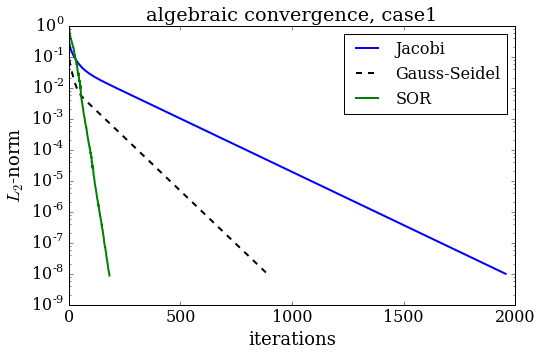

In [30]:
plot_algb_conv(ej_c1_w1_g1, egs_c1_w1_g1 , esor_c1_w1_g1,'algebraic convergence, case1')
pyplot.savefig('algb_conv_c1_g1_w1.png')

In [31]:
def grid_refine(numxg, numyg, Xcg, Ycg, dxg, dyg, n_freq, w):
    #
    ngrid = numpy.size(numxg)
    #
    errorJ = numpy.empty((ngrid), dtype=float)
    errorGS = numpy.empty( (ngrid), dtype=float)
    errorSOR = numpy.empty((ngrid), dtype=float)
    #
    for i in range(ngrid):
        #initial guess
        pg_init = init_poisson(numxg[i], numyg[i])
        # RHS
        fg = get_RHS(Xcg[i], Ycg[i], n_freq)
        #solutions
        pJ, iterJ, l2eJ = jacobi_dirichlet(pg_init.copy(),\
                                        fg.copy(), numxg[i], numyg[i], dxg[i],\
                                           dyg[i], l2_target)
        pGS, iterGS, l2eGS = GS_dirichlet( pg_init.copy(), pg_init.copy(),\
                                         fg.copy(), numxg[i], numyg[i], dxg[i],\
                                          dyg[i], l2_target)

        pSOR, iterSOR, l2eSOR = SOR_dirichlet(pg_init.copy(), pg_init.copy(),\
                                         fg.copy(), numxg[i], numyg[i], dxg[i],\
                                          dyg[i], l2_target, w)
        
        #analytical function
        pg_an = p_analytical(Xcg[i], Ycg[i], n_freq)
        #Errors
        errorJ[i] = L2_error_2(pJ, pg_an)
        errorGS[i] = L2_error_2(pGS, pg_an)
        errorSOR[i] = L2_error_2(pSOR, pg_an)
        #
    return errorJ, errorGS, errorSOR

In [32]:
errj, errgs, errsor = grid_refine(nxc[:-1], nyc[:-1],\
                                  Xc[:-1], Yc[:-1], dx[:-1], dy[:-1], nf[0], 1.9)

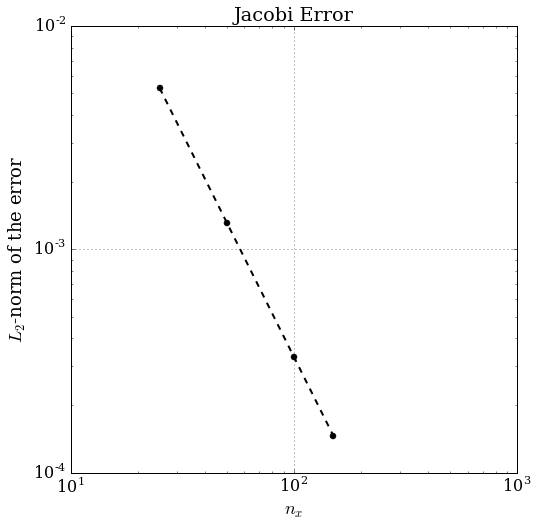

In [33]:
plot_error_grid_refine(errj,nxc[:-1], 'Jacobi Error')
pyplot.savefig('errj_c1_g1_w1.png')

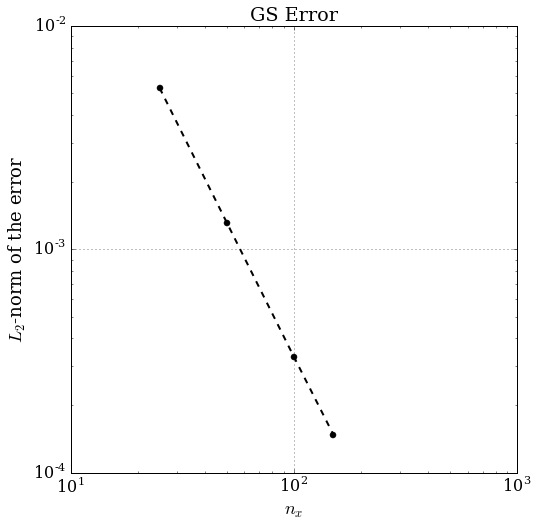

In [34]:
plot_error_grid_refine(errgs,nxc[:-1], 'GS Error')
pyplot.savefig('errgs_c1_g1_w1.png')

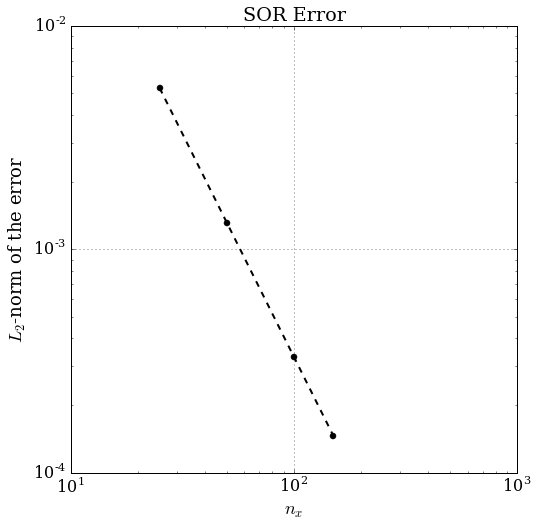

In [35]:
plot_error_grid_refine(errsor,nxc[:-1], 'SOR Error')
pyplot.savefig('errsor_c1_g1_w1.png')

### Relaxation Parameter Analysis

In [36]:
w_val = [1.2, 1.4, 1.6, 1.8, 1.9]

In [37]:
#SOR_dirichlet(p, pk, f, numx, numy, delx, dely, l2_target, w)

In [42]:
def get_SOR_converge(w_values,numx,numy,delx,dely,xp,yp,Xp,Yp, n_freq): 
    #
    errorSORw = numpy.empty_like(w_values, dtype=numpy.float)
#     errorSORnw = numpy.empty_like(w_values, dtype=numpy.float)
    #
    rel_er_c1 = numpy.empty((5,20000), dtype=numpy.float)
#     rel_er_c2 = numpy.empty((5,20000), dtype=numpy.float)
    #
    pg_init = init_poisson(numx,numy)
    # RHS functions
    fg1 = get_RHS(Xp,Yp,n_freq)
#     fg2 = get_RHS_2(Xg,Yg,n_freq)
    #
    for i, w in enumerate(w_values):

        #SOR
        p_SORw, iterSORw, l2eSORw = SOR_dirichlet(pg_init.copy(), pg_init.copy(), fg1.copy(),\
                                        numx, numy, delx, dely, l2_target, w)
#         p_SORnw, iterSORnw, l2eSORnw = SOR_neumann(w, pg_init.copy(), pg_init.copy(), fg2,\
#                                                    l2_target, ng, ng, dxg, dyg)
        #Analytical Values
        pw_an = p_analytical(Xp,Yp,n_freq)
#         pw_an2 = p_analytical2(Xg,Yg,nf)
        #Errors
        errorSORw[i] = L2_error(p_SORw, pw_an)
#         errorSORnw[i] = L2_error(p_SORnw, pw_an2)
        #
        rel_er_c1[i,:] = l2eSORw[:]
#         rel_er_c2[i,:] = l2eSORnw[:]
        #
        #
    return rel_er_c1, errorSORw # ,rel_er_c2, errorSORnw

In [45]:
err_rel_c1_g1_w1,err_an_c1_g1_w1 = get_SOR_converge(w_val,nxc[0],\
                                                    nyc[0],dx[0],dy[0],xc[0],yc[0],\
                                                    Xc[0],Yc[0], nf[0])

In [165]:
err_rel_c1_g3_w1,err_an_c1_g3_w1 = get_SOR_converge(w_val,nxc[2],\
                                                    nyc[2],dx[2],dy[2],xc[2],yc[2],\
                                                    Xc[2],Yc[2], nf[0])

In [168]:
nxc[2]

100

In [46]:
def plot_err_w(err_v, title, label1, label2, label3, label4, label5):
    pyplot.figure(figsize=(8,5))
    pyplot.title(title)
    pyplot.xlabel(r'iterations', fontsize=18)
    pyplot.ylabel(r'$L_2$-norm', fontsize=18)
    pyplot.semilogy(numpy.trim_zeros(err_v[0,:],'b'),
            'b-', lw=2, label=label1)
    pyplot.semilogy(numpy.trim_zeros(err_v[1,:],'b'), 
            'k--', lw=2, label=label2)
    pyplot.semilogy(numpy.trim_zeros(err_v[2,:],'b'), 
            'y-', lw=2, label=label3)
    pyplot.semilogy(numpy.trim_zeros(err_v[3,:],'b'), 
            'g--', lw=2, label=label4)
    pyplot.semilogy(numpy.trim_zeros(err_v[4,:],'b'), 
            'r-', lw=2, label=label5)
    pyplot.legend(fontsize=16);

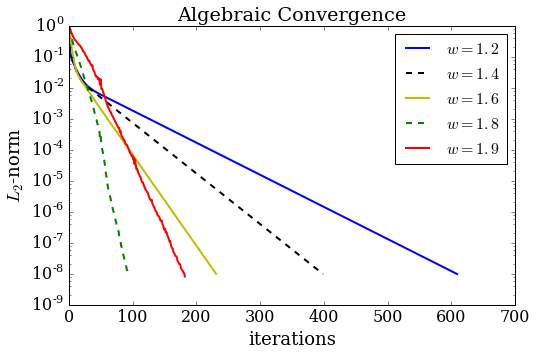

In [48]:
plot_err_w(err_rel_c1_g1_w1, 'Algebraic Convergence', '$w=1.2$',\
           '$w = 1.4$','$w = 1.6$' , '$w = 1.8$', '$w = 1.9$')
pyplot.savefig('algb_conv_c1_g1_w1_omega.png')

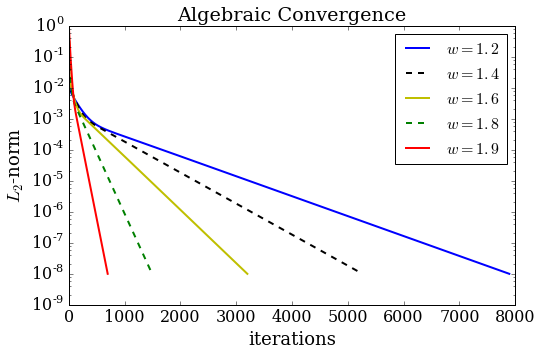

In [167]:
plot_err_w(err_rel_c1_g3_w1, 'Algebraic Convergence', '$w=1.2$',\
           '$w = 1.4$','$w = 1.6$' , '$w = 1.8$', '$w = 1.9$')
pyplot.savefig('algb_conv_c1_g3_w1_omega.png')

In [173]:
err_an_c1_g1_w1

array([ 0.00528046,  0.00528046,  0.00528046,  0.00528045,  0.00528045])

In [174]:
err_an_c1_g3_w1

array([ 0.00032912,  0.00032908,  0.00032906,  0.00032906,  0.00032907])

In [50]:
def err_plot(w_vals, errvec, title):
    pyplot.figure(figsize=(8,8))
    pyplot.grid(True)
    pyplot.xlabel(r'$\omega$', fontsize=18)
    pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)
    # pyplot.ylim(2.5e-4,4e-4)
    #pyplot.xlim(1.,2.)
    pyplot.title(title)
    pyplot.plot(w_vals, errvec, color='k', ls='--', lw=2, marker='o');
    pyplot.axis('equal');

In [67]:
def err_plot2(n_freq, errvec, title):
    pyplot.figure(figsize=(8,8))
    pyplot.grid(True)
    pyplot.xlabel(r'$frequency$', fontsize=18)
    pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)
    # pyplot.ylim(2.5e-4,4e-4)
    #pyplot.xlim(1.,2.)
    pyplot.title(title)
    pyplot.plot(n_freq, errvec, color='k', ls='--', lw=2, marker='o');
    pyplot.axis('equal');

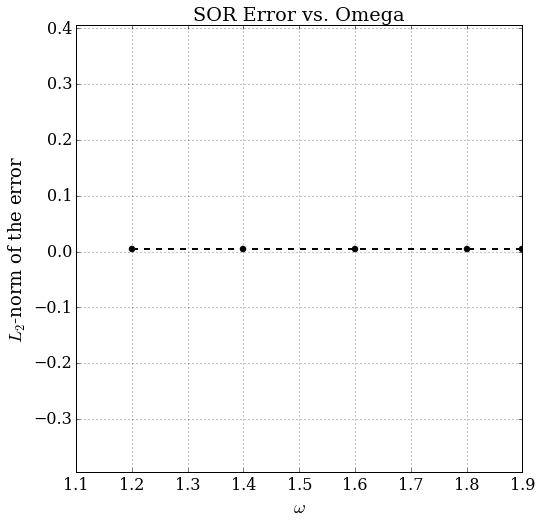

In [52]:
err_plot(w_val, err_an_c1_g1_w1, 'SOR Error vs. Omega')
pyplot.savefig('err_an_c1_g1_w1_omega.png')

##### Let's see what happens to the errror as we increase the frequency on the same grid using the SOR method

In [54]:
err_rel_c1_g1_w2,err_an_c1_g1_w2 = get_SOR_converge(w_val,nxc[0],\
                                                    nyc[0],dx[0],dy[0],xc[0],yc[0],\
                                                    Xc[0],Yc[0], nf[1])

In [55]:
err_rel_c1_g1_w3,err_an_c1_g1_w3 = get_SOR_converge(w_val,nxc[0],\
                                                    nyc[0],dx[0],dy[0],xc[0],yc[0],\
                                                    Xc[0],Yc[0], nf[2])

In [56]:
err_rel_c1_g1_w4,err_an_c1_g1_w4 = get_SOR_converge(w_val,nxc[0],\
                                                    nyc[0],dx[0],dy[0],xc[0],yc[0],\
                                                    Xc[0],Yc[0], nf[3])

In [61]:
err_rel_c1_g1_w5,err_an_c1_g1_w5 = get_SOR_converge(w_val,nxc[0],\
                                                    nyc[0],dx[0],dy[0],xc[0],yc[0],\
                                                    Xc[0],Yc[0], nf[4])

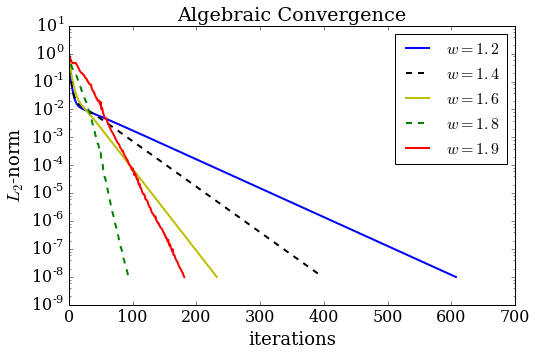

In [57]:
plot_err_w(err_rel_c1_g1_w2, 'Algebraic Convergence', '$w=1.2$',\
           '$w = 1.4$','$w = 1.6$' , '$w = 1.8$', '$w = 1.9$')
pyplot.savefig('algb_conv_c1_g1_w2_omega.png')

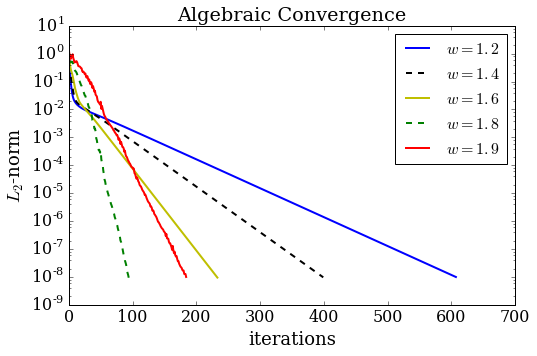

In [58]:
plot_err_w(err_rel_c1_g1_w3, 'Algebraic Convergence', '$w=1.2$',\
           '$w = 1.4$','$w = 1.6$' , '$w = 1.8$', '$w = 1.9$')
pyplot.savefig('algb_conv_c1_g1_w3_omega.png')

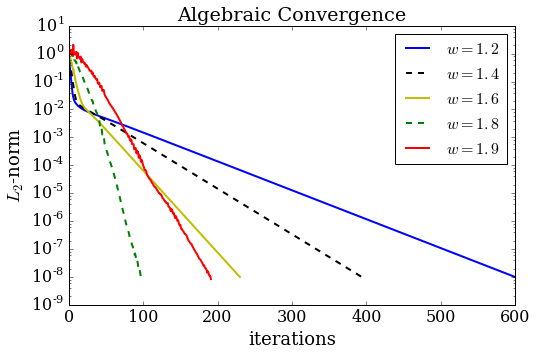

In [59]:
plot_err_w(err_rel_c1_g1_w4, 'Algebraic Convergence', '$w=1.2$',\
           '$w = 1.4$','$w = 1.6$' , '$w = 1.8$', '$w = 1.9$')
pyplot.savefig('algb_conv_c1_g1_w4_omega.png')

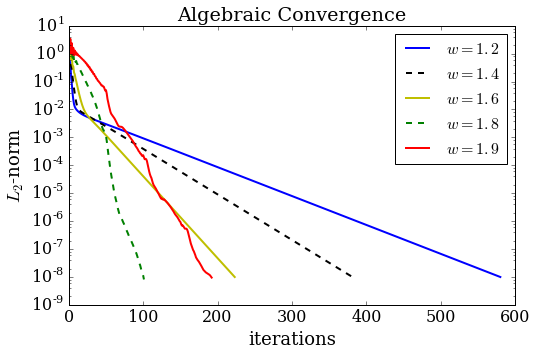

In [62]:
plot_err_w(err_rel_c1_g1_w5, 'Algebraic Convergence', '$w=1.2$',\
           '$w = 1.4$','$w = 1.6$' , '$w = 1.8$', '$w = 1.9$')
pyplot.savefig('algb_conv_c1_g1_w5_omega.png')

In [63]:
err_freq_c1_g1 = [err_an_c1_g1_w1[0], err_an_c1_g1_w2[0], err_an_c1_g1_w3[0],\
                 err_an_c1_g1_w4[0], err_an_c1_g1_w5[0] ]

In [69]:
err_an_c1_g1_w1[0]

0.0052804564491677163

In [70]:
err_an_c1_g1_w5[0] 

1.2829577559071164

In [71]:
err_an_c1_g1_w5[0] /err_an_c1_g1_w1[0]

242.96341959402599

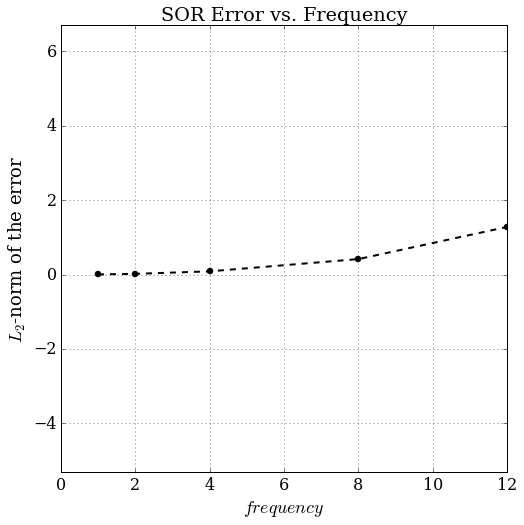

In [68]:
err_plot2(nf, err_freq_c1_g1, 'SOR Error vs. Frequency')
pyplot.savefig('err_an_c1_g1_nfreq.png')

#### Now the objective is to solve for higher frequencies and keep the error down - then we need to refine the grid!

#### frequency = 8.0

In [73]:
#nf = 8.0
err_rel_c1_g2_w4,err_an_c1_g2_w4 = get_SOR_converge(w_val,nxc[1],\
                                                    nyc[1],dx[1],dy[1],xc[1],yc[1],\
                                                    Xc[1],Yc[1], nf[3])

In [74]:
err_rel_c1_g3_w4,err_an_c1_g3_w4 = get_SOR_converge(w_val,nxc[2],\
                                                    nyc[2],dx[2],dy[2],xc[2],yc[2],\
                                                    Xc[2],Yc[2], nf[3])

In [78]:
err_rel_c1_g4_w4,err_an_c1_g4_w4 = get_SOR_converge(w_val,nxc[3],\
                                                    nyc[3],dx[3],dy[3],xc[3],yc[3],\
                                                    Xc[3],Yc[3], nf[3])

In [79]:
err_rel_c1_g5_w4,err_an_c1_g5_w4 = get_SOR_converge(w_val,nxc[4],\
                                                    nyc[4],dx[4],dy[4],xc[4],yc[4],\
                                                    Xc[4],Yc[4], nf[3])

In [80]:
err_freq_c1_nfreq = [err_an_c1_g1_w4[0], err_an_c1_g2_w4[0], err_an_c1_g3_w4[0],\
                 err_an_c1_g4_w4[0], err_an_c1_g5_w4[0] ]

In [82]:
err_an_c1_g1_w4[0]

0.41767733147869474

In [83]:
err_an_c1_g5_w4[0]

0.0052805250288325122

In [84]:
err_an_c1_g1_w4[0]/err_an_c1_g5_w4[0]

79.097689945244014

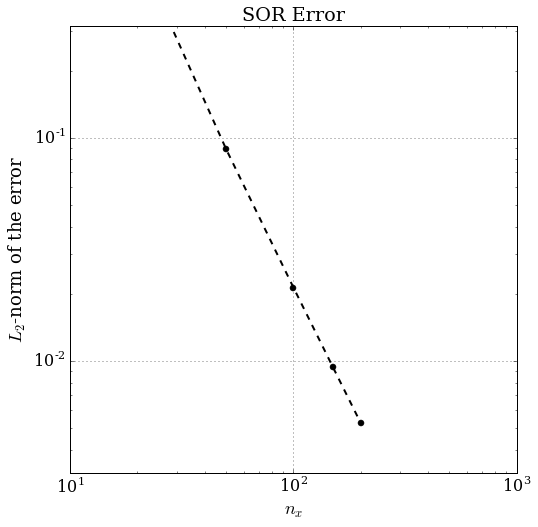

In [81]:
plot_error_grid_refine(err_freq_c1_nfreq,nxc, 'SOR Error')
pyplot.savefig('errsor_c1_w4_nfreq.png')

#### frequency = 12.0

In [86]:
err_rel_c1_g2_w5,err_an_c1_g2_w5 = get_SOR_converge(w_val,nxc[1],\
                                                    nyc[1],dx[1],dy[1],xc[1],yc[1],\
                                                    Xc[1],Yc[1], nf[4])

In [87]:
err_rel_c1_g3_w5,err_an_c1_g3_w5 = get_SOR_converge(w_val,nxc[2],\
                                                    nyc[2],dx[2],dy[2],xc[2],yc[2],\
                                                    Xc[2],Yc[2], nf[4])

In [88]:
err_rel_c1_g4_w5,err_an_c1_g4_w5 = get_SOR_converge(w_val,nxc[3],\
                                                    nyc[3],dx[3],dy[3],xc[3],yc[3],\
                                                    Xc[3],Yc[3], nf[4])

In [89]:
err_rel_c1_g5_w5,err_an_c1_g5_w5 = get_SOR_converge(w_val,nxc[4],\
                                                    nyc[4],dx[4],dy[4],xc[4],yc[4],\
                                                    Xc[4],Yc[4], nf[4])

In [93]:
err_freq_c1_nfreq_w5 = [err_an_c1_g1_w5[0], err_an_c1_g2_w5[0], err_an_c1_g3_w5[0],\
                 err_an_c1_g4_w5[0], err_an_c1_g5_w5[0] ]

In [91]:
err_an_c1_g1_w5[0]

1.2829577559071164

In [92]:
err_an_c1_g5_w5[0]

0.011928195020386992

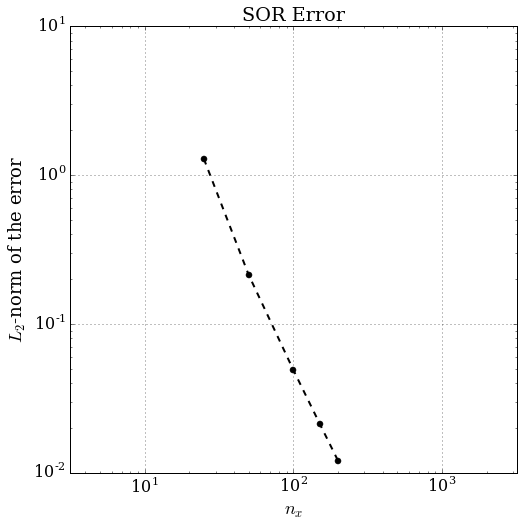

In [94]:
plot_error_grid_refine(err_freq_c1_nfreq_w5,nxc, 'SOR Error')
pyplot.savefig('errsor_c1_w5_nfreq.png')

## CASE 2 - HOMOGENEOUS NEUMANN BCs

##### Source Term functions

In [95]:
f2_g1_w1 = get_RHS_2(Xc[1],Yc[1],nf[0])
# f2_g2_w1 = get_RHS_2(Xc[2],Yc[2],nf[0])
# f2_g3_w1 = get_RHS_2(Xc[3],Yc[3],nf[0])
# f2_g4_w1 = get_RHS_2(Xc[4],Yc[4],nf[0])

##### Analytical solutions

In [96]:

p_an2_g1_w1 = p_analytical2(Xc[1], Yc[1], nf[0])
# p_an2_g2_w1 = p_analytical2(Xc[2], Yc[2], nf[0])
# p_an2_g3_w1 = p_analytical2(Xc[3], Yc[3], nf[0])
# p_an2_g4_w1 = p_analytical2(Xc[4], Yc[4], nf[0])

##### Initial Guesses

In [97]:
p_init_g1_c2 = numpy.zeros((nxc[1], nyc[1]))
# p_init_g2_c2 = numpy.zeros((nxc[2], nyc[2]))
# p_init_g3_c2 = numpy.zeros((nxc[3], nyc[3]))
# p_init_g4_c2 = numpy.zeros((nxc[4], nyc[4]))


### Jacobi Method

In [98]:
def jacobi_neumann(p, f, numx, numy, delx, dely, l2t):
    ''' Jacobi iteration to solve
    
    Parameters:
    ----------
    p : 2D array initial guess
    f : 2D array source term
    delx: spacing in x direction
    dely: spacing in y direction
    l2_target: target difference consecutive iterations
    
    Returns:
    -------
    p: 2D array of float solution
    iterations: number of iterations to convergence
    l2_err: l2 norm of error
    '''
    l2_norm = 1.1 + l2t
    iterations = 0
    l2_err = []
    #
    itermax = 1e6
    
    while l2_norm > l2t:
        #
        pk = p.copy()
        #
        p[1:-1,1:-1] = (1/(2*(delx**2 + dely**2))) * \
                       ( (dely**2)*( pk[2:,1:-1] + pk[:-2,1:-1]) +\
                         (delx**2)*( pk[1:-1,2:] + pk[1:-1,:-2]) -\
                         (delx**2)*(dely**2)*f[1:-1,1:-1])
        # Neumann BCs
        #left boundary
        p[0,1:-1] = (1/(2*(delx**2) + dely**2))*\
                    ((pk[1,1:-1]*(dely**2) + (pk[0,2:] + pk[0,:-2])*(delx**2)) -\
                    (delx**2)*(dely**2)*f[0,1:-1])
        #right boundary
        p[-1,1:-1]= (1/(2*(delx**2) + dely**2))*\
                    ( ( pk[-2,1:-1]*(dely**2) + ( pk[-1,2:] + pk[-1,:-2] )*(delx**2) ) -\
                       (delx**2)*(dely**2)*f[-1,1:-1]  )
            
        #bottom boundary:
        p[1:-1,0] = (1/(delx**2 + 2*(dely**2)))*\
                    ( ((pk[2:,0] + pk[:-2,0])*(dely**2) +\
                       (delx**2)*pk[1:-1,1] -\
                       (delx**2)*(dely**2)*f[1:-1,0])) 
        #top boundary: 
        p[1:-1,-1] = (1/(delx**2 + 2*(dely**2)))*\
                    ( ((pk[2:,-1] + pk[:-2,-1])*(dely**2) + pk[1:-1,-2]*(delx**2)) -\
                     (delx**2)*(dely**2)*f[1:-1,-1])
        # corners
        p[0,0] = (1/((delx**2 + dely**2)))*\
                 ((pk[1,0]*(dely**2) + (pk[0,1])*(delx**2)) -\
                  (delx**2)*(dely**2)*f[0,0])
        #
        p[-1,0] = (1/((delx**2 + dely**2)))*\
                 ((pk[-2,0]*(dely**2) + (pk[-1,1] )*(delx**2)) -\
                  (delx**2)*(dely**2)*f[-1,0])
        #
        p[-1,-1] = (1/((delx**2 + dely**2)))*\
                 ((pk[-2,-1]*(dely**2) + (pk[-1,-2])*(delx**2)) -\
                  (delx**2)*(dely**2)*f[-1,-1])
        #
        p[0,-1] = (1/((delx**2 + dely**2)))*\
                 ((pk[1,-1]*(dely**2) + (pk[0,-2] )*(delx**2)) -\
                  (delx**2)*(dely**2)*f[0,-1])
        #
        if (iterations>itermax):
            print('maximum iterations reached')
            break
            
        l2_norm = L2_error_2(p,pk)
        iterations += 1
        l2_err.append(l2_norm)
        #
    return p, iterations, l2_err

In [99]:
pj_c2_w1_g1,\
    iterj_c2_w1_g1, ej_c2_w1_g1 = jacobi_neumann(p_init_g1_c2.copy(), \
                                    f2_g1_w1.copy(), nxc[1], nyc[1], dx[1],\
                                                 dy[1], l2_target)

/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in double_scalars


In [100]:
L2_error(p_an2_g1_w1, pj_c2_w1_g1)

0.0013152541987123171

### Gauss-Sidel Method

In [101]:
#@jit(nopython=True)
def GS_neumann(p, pk, f, numx, numy, delx, dely, l2_target):
    #
    iterations = 0 
    iter_diff = l2_target + 1.1
    denominator = 0.0
    l2_err = numpy.zeros(20000)
    itermax = 20000
    #
    while iter_diff > l2_target:
        #
        for i in range(numx):
            for j in range(numy):
                pk[i,j] = p[i,j]
        #
        iter_diff = 0.0
        denominator = 0.0
        #
        for i in range(1,numx-1):
            for j in range(1, numy-1):
                p[i,j] = (1/(2*(delx**2 + dely**2))) * \
                        ( (dely**2)*( p[i+1,j] + p[i-1,j]) +\
                         (delx**2)*( p[i,j+1] + p[i,j-1]) -\
                         (delx**2)*(dely**2)*f[i,j])
        #
        #Boundary Conditions for cell-centered grid:
        #
        for i in range(1,numx-1):
            #bottom boundary:
            p[i,0] = (1/(delx**2 + 2*(dely**2)))*\
                        ((dely**2)*(p[i+1,0] + p[i-1,0]) +\
                        (delx**2)*p[i,1] - \
                        (delx**2)*(dely**2)*f[i,0])
            #top boundary:
            p[i,-1] = (1/(delx**2 + 2*(dely**2)))*\
                        ((dely**2)*(p[i+1,-1] + p[i-1,-1]) +\
                        (delx**2)*p[i,-2] -\
                        (delx**2)*(dely**2)*f[i,-1])
        for j in range(1,numy-1):
            #left boundary:
            p[0,j] = (1/(dely**2 + 2*(delx**2)))*\
                        ((dely**2)*(p[1,j]) +\
                        (delx**2)*(p[0,j+1] + p[0,j-1]) -\
                        (delx**2)*(dely**2)*f[0,j])
            #right boundary:
            p[-1,j] = (1/(dely**2 + 2*(delx**2)))*\
                        ((dely**2)*p[-2,j] +\
                        (delx**2)*(p[-1,j+1] + p[-1,j-1]) -\
                        (delx**2)*(dely**2)*f[-1,j])
        # corners:
        p[0,0] = (1/(delx**2 + dely**2))*\
                    ((dely**2)*p[1,0] +\
                    (delx**2)*p[0,1] -\
                    (delx**2)*(dely**2)*f[0,0])
        #
        p[0,-1] = (1/(delx**2 + dely**2))*\
                    ((dely**2)*p[1,-1] +\
                    (delx**2)*p[0,-2] -\
                    (delx**2)*(dely**2)*f[0,-1])
        #
        p[-1,-1] = (1/(delx**2 + dely**2))*\
                    ((dely**2)*p[-2,-1] +\
                    (delx**2)*p[-1,-2] -\
                    (delx**2)*(dely**2)*f[-1,-1])
        #
        p[-1,0] = (1/(delx**2 + dely**2))*\
                    ((dely**2)*p[-2,0] +\
                    (delx**2)*p[-1,1] -\
                    (delx**2)*(dely**2)*f[-1,0])
        #
        for i in range(1,numx-1):
            for j in range(1,numy-1):
                iter_diff += (p[i,j] - pk[i,j])**2
                denominator += (pk[i,j]*pk[i,j])
        #
        iter_diff /= denominator
        iter_diff = iter_diff**0.5
        l2_err[iterations] = iter_diff
        iterations += 1
        #
        if (iterations>itermax):
            print('maximum iterations reached')
            break
        
    return p, iterations, l2_err

In [102]:
pgs_c2_w1_g1,\
    itergs_c2_w1_g1, egs_c2_w1_g1 = GS_neumann(p_init_g1_c2.copy(),\
                                                 p_init_g1_c2.copy(), \
                                    f2_g1_w1.copy(), nxc[1], nyc[1], dx[1],\
                                                 dy[1], l2_target)

/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:49: RuntimeWarning: divide by zero encountered in double_scalars


In [103]:
L2_error(p_an2_g1_w1, pgs_c2_w1_g1)

0.0013152635554114828

### SOR Method

In [104]:
def SOR_neumann(p, pk, f, numx, numy, delx, dely, l2_target, w):
    #
    iterations = 0 
    iter_diff = l2_target + 1.1
    denominator = 0.0
    l2_err = numpy.zeros(20000)
    itermax = 20000
    #
    while iter_diff > l2_target:
        #
        for i in range(numx):
            for j in range(numy):
                pk[i,j] = p[i,j]
        #
        iter_diff = 0.0
        denominator = 0.0
        #
        for i in range(1,numx-1):
            for j in range(1, numy-1):
                p[i,j] = (1-w)*pk[i,j] + (w/(2*(delx**2 + dely**2))) * \
                        ( (dely**2)*( p[i+1,j] + p[i-1,j]) +\
                         (delx**2)*( p[i,j+1] + p[i,j-1]) -\
                         (delx**2)*(dely**2)*f[i,j])
        #
        #Boundary Conditions for cell-centered grid:
        #
        for i in range(1,numx-1):
            #bottom boundary:
            p[i,0] = (1-w)*pk[i,0] + (w/(delx**2 + 2*(dely**2)))*\
                        ((dely**2)*(p[i+1,0] + p[i-1,0]) +\
                        (delx**2)*p[i,1] - \
                        (delx**2)*(dely**2)*f[i,0])
            #top boundary:
            p[i,-1] = (1-w)*pk[i,-1] + (w/(delx**2 + 2*(dely**2)))*\
                        ((dely**2)*(p[i+1,-1] + p[i-1,-1]) +\
                        (delx**2)*p[i,-2] -\
                        (delx**2)*(dely**2)*f[i,-1])
        for j in range(1,numy-1):
            #left boundary:
            p[0,j] = (1-w)*pk[0,j] + (w/(dely**2 + 2*(delx**2)))*\
                        ((dely**2)*(p[1,j]) +\
                        (delx**2)*(p[0,j+1] + p[0,j-1]) -\
                        (delx**2)*(dely**2)*f[0,j])
            #right boundary:
            p[-1,j] = (1-w)*pk[-1,j] + (w/(dely**2 + 2*(delx**2)))*\
                        ((dely**2)*p[-2,j] +\
                        (delx**2)*(p[-1,j+1] + p[-1,j-1]) -\
                        (delx**2)*(dely**2)*f[-1,j])
        # corners:
        p[0,0] = (1-w)*pk[0,0] + (w/(delx**2 + dely**2))*\
                    ((dely**2)*p[1,0] +\
                    (delx**2)*p[0,1] -\
                    (delx**2)*(dely**2)*f[0,0])
        #
        p[0,-1] = (1-w)*pk[0,-1] + (w/(delx**2 + dely**2))*\
                    ((dely**2)*p[1,-1] +\
                    (delx**2)*p[0,-2] -\
                    (delx**2)*(dely**2)*f[0,-1])
        #
        p[-1,-1] = (1-w)*pk[-1,-1] + (w/(delx**2 + dely**2))*\
                    ((dely**2)*p[-2,-1] +\
                    (delx**2)*p[-1,-2] -\
                    (delx**2)*(dely**2)*f[-1,-1])
        #
        p[-1,0] = (1-w)*pk[-1,0] + (w/(delx**2 + dely**2))*\
                    ((dely**2)*p[-2,0] +\
                    (delx**2)*p[-1,1] -\
                    (delx**2)*(dely**2)*f[-1,0])
        #
        for i in range(1,numx-1):
            for j in range(1,numy-1):
                iter_diff += (p[i,j] - pk[i,j])**2
                denominator += (pk[i,j]*pk[i,j])
        #
        iter_diff /= denominator
        iter_diff = iter_diff**0.5
        l2_err[iterations] = iter_diff
        iterations += 1
        #
        if (iterations>itermax):
            print('maximum iterations reached')
            break
        
    return p, iterations, l2_err

In [105]:
psor_c2_w1_g1,\
    itersor_c2_w1_g1, esor_c2_w1_g1 = SOR_neumann(p_init_g1_c2.copy(),\
                                                 p_init_g1_c2.copy(), \
                                    f2_g1_w1.copy(), nxc[1], nyc[1], dx[1],\
                                                 dy[1], l2_target, 1.9)

/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in double_scalars


In [106]:
L2_error(p_an2_g1_w1, psor_c2_w1_g1)

0.0013152574225139954

### Grid Refinement

In [107]:
def grid_refine_c2(numxg, numyg, Xcg, Ycg, dxg, dyg, n_freq, w):
    #
    ngrid = numpy.size(numxg)
    l2_target = 1e-8
    #
    errorJ = numpy.empty((ngrid), dtype=float)
    errorGS = numpy.empty( (ngrid), dtype=float)
    errorSOR = numpy.empty((ngrid), dtype=float)
    #
    for i in range(ngrid):
        #initial guess
        pg_init = numpy.zeros((numxg[i], numyg[i]))
        # RHS
        fg = get_RHS_2(Xcg[i], Ycg[i], n_freq)
        #solutions
        pJ, iterJ, l2eJ = jacobi_neumann(pg_init.copy(),\
                                        fg.copy(), numxg[i], numyg[i], dxg[i],\
                                           dyg[i], l2_target)
        pGS, iterGS, l2eGS = GS_neumann( pg_init.copy(), pg_init.copy(),\
                                         fg.copy(), numxg[i], numyg[i], dxg[i],\
                                          dyg[i], l2_target)

        pSOR, iterSOR, l2eSOR = SOR_neumann(pg_init.copy(), pg_init.copy(),\
                                         fg.copy(), numxg[i], numyg[i], dxg[i],\
                                          dyg[i], l2_target, w)
        
        #analytical function
        pg_an = p_analytical2(Xcg[i], Ycg[i], n_freq)
        #Errors
        errorJ[i] = L2_error_2(pJ, pg_an)
        errorGS[i] = L2_error_2(pGS, pg_an)
        errorSOR[i] = L2_error_2(pSOR, pg_an)
        #
    return errorJ, errorGS, errorSOR

In [108]:
errj_c2_w1, errgs_c2_w1, errsor_c2_w1 = grid_refine_c2(nxc[1:], nyc[1:],\
                                  Xc[1:], Yc[1:], dx[1:], dy[1:], nf[0], 1.8)

/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:49: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in double_scalars


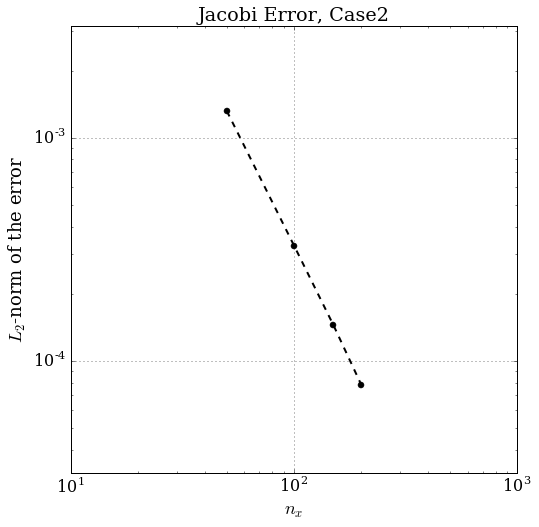

In [109]:
plot_error_grid_refine(errj_c2_w1,nxc[1:], 'Jacobi Error, Case2')
pyplot.savefig('errj_c2_g1_w1.png')

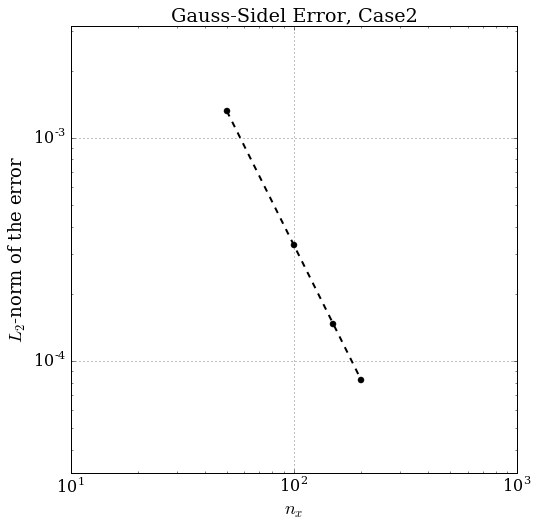

In [110]:
plot_error_grid_refine(errgs_c2_w1,nxc[1:], 'Gauss-Sidel Error, Case2')
pyplot.savefig('errgs_c2_g1_w1.png')

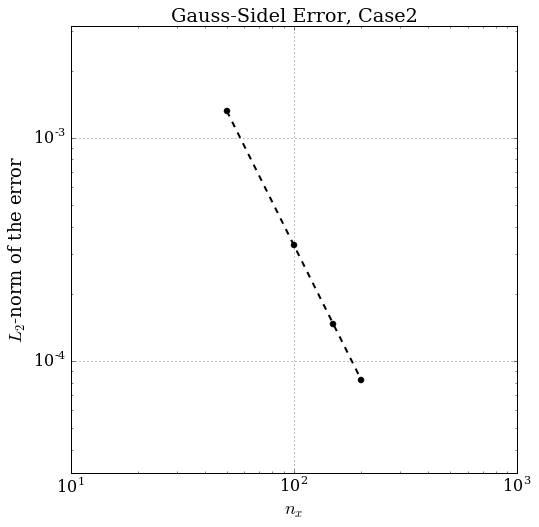

In [111]:
plot_error_grid_refine(errsor_c2_w1,nxc[1:], 'Gauss-Sidel Error, Case2')
pyplot.savefig('errsor_c2_g1_w1.png')

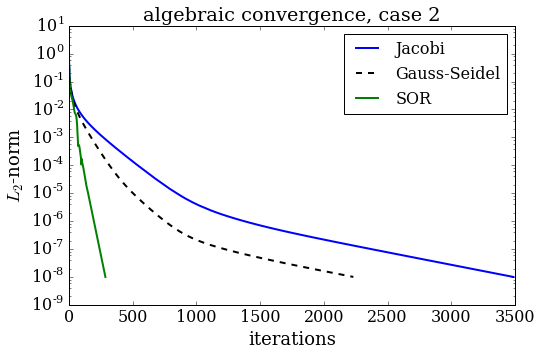

In [112]:
plot_algb_conv(ej_c2_w1_g1, egs_c2_w1_g1 , esor_c2_w1_g1,'algebraic convergence, case 2')
pyplot.savefig('algb_conv_c2_g1_w1.png')

### Relaxation Parameter Analysis

In [135]:
def get_SOR_converge_c2(w_values,numx,numy,delx,dely,xp,yp,Xp,Yp, n_freq): 
    #
    errorSORw = numpy.empty_like(w_values, dtype=numpy.float)
    #
    rel_er_c1 = numpy.empty((5,20000), dtype=numpy.float)
    #
    pg_init = numpy.zeros((numx,numy))
    fg1 = get_RHS_2(Xp,Yp,n_freq)
    #
    for i, w in enumerate(w_values):
        #SOR
        p_SORw, iterSORw, l2eSORw = SOR_neumann(pg_init.copy(), pg_init.copy(), fg1.copy(),\
                                        numx, numy, delx, dely, l2_target, w)
        #Analytical Values
        pw_an = p_analytical2(Xp,Yp,n_freq)
        #error
        errorSORw[i] = L2_error_2(p_SORw, pw_an)
        rel_er_c1[i,:] = l2eSORw[:]
        #
    return rel_er_c1, errorSORw 

In [136]:
err_rel_c2_g1_w1,err_an_c2_g1_w1 = get_SOR_converge_c2(w_val,nxc[0],\
                                                    nyc[0],dx[0],dy[0],xc[0],yc[0],\
                                                    Xc[0],Yc[0], nf[0])

/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in double_scalars


In [169]:
err_rel_c2_g3_w1,err_an_c2_g3_w1 = get_SOR_converge_c2(w_val,nxc[2],\
                                                    nyc[2],dx[2],dy[2],xc[2],yc[2],\
                                                    Xc[2],Yc[2], nf[0])

/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in double_scalars


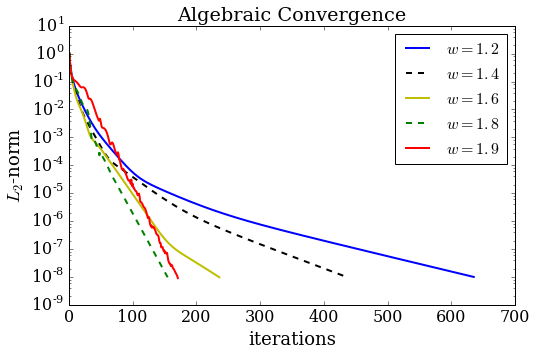

In [137]:
plot_err_w(err_rel_c2_g1_w1, 'Algebraic Convergence', '$w=1.2$',\
           '$w = 1.4$','$w = 1.6$' , '$w = 1.8$', '$w = 1.9$')
pyplot.savefig('algb_conv_c2_g1_w1_omega.png')

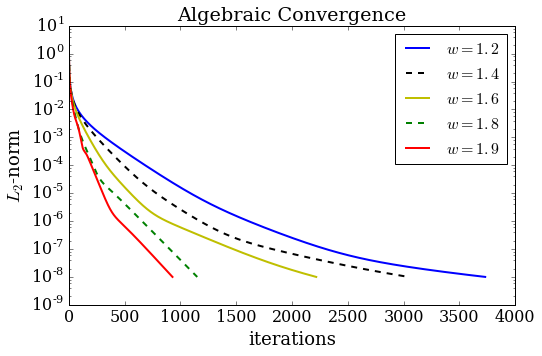

In [171]:
plot_err_w(err_rel_c2_g3_w1, 'Algebraic Convergence', '$w=1.2$',\
           '$w = 1.4$','$w = 1.6$' , '$w = 1.8$', '$w = 1.9$')
pyplot.savefig('algb_conv_c2_g3_w1_omega.png')

In [138]:
err_an_c2_g1_w1

array([ 0.00528046,  0.00528046,  0.00528045,  0.00528045,  0.00528047])

In [172]:
err_an_c2_g3_w1

array([ 0.00032923,  0.00032914,  0.00032908,  0.00032904,  0.00032905])

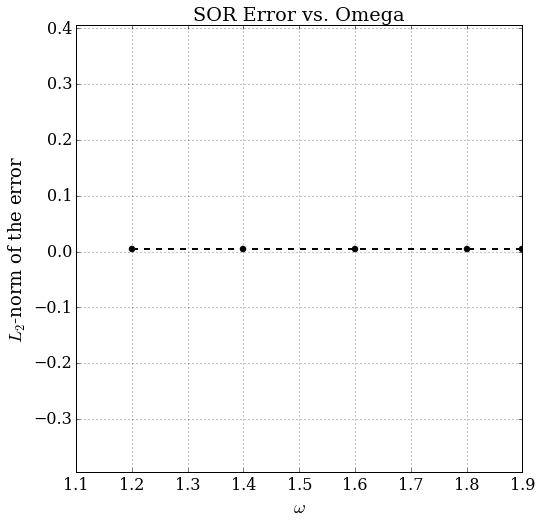

In [139]:
err_plot(w_val, err_an_c2_g1_w1, 'SOR Error vs. Omega')
pyplot.savefig('err_an_c2_g1_w1_omega.png')

#### This shows that the error stays consistent with varying omega

##### Let's see what happens to the errror as we increase the frequency on the same grid using the SOR method

In [140]:
err_rel_c2_g1_w2, err_an_c2_g1_w2 = get_SOR_converge_c2(w_val,nxc[0],\
                                                    nyc[0],dx[0],dy[0],xc[0],yc[0],\
                                                    Xc[0],Yc[0], nf[1])

/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in double_scalars


In [141]:
err_rel_c2_g1_w3,err_an_c2_g1_w3 = get_SOR_converge_c2(w_val,nxc[0],\
                                                    nyc[0],dx[0],dy[0],xc[0],yc[0],\
                                                    Xc[0],Yc[0], nf[2])

/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in double_scalars


In [142]:
err_rel_c2_g1_w4,err_an_c2_g1_w4 = get_SOR_converge_c2(w_val,nxc[0],\
                                                    nyc[0],dx[0],dy[0],xc[0],yc[0],\
                                                    Xc[0],Yc[0], nf[3])

/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in double_scalars


In [143]:
err_rel_c2_g1_w5,err_an_c2_g1_w5 = get_SOR_converge_c2(w_val,nxc[0],\
                                                    nyc[0],dx[0],dy[0],xc[0],yc[0],\
                                                    Xc[0],Yc[0], nf[4])

/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in double_scalars


In [144]:
err_freq_c2_g1 = [err_an_c2_g1_w1[0], err_an_c2_g1_w2[0], err_an_c2_g1_w3[0],\
                 err_an_c2_g1_w4[0], err_an_c2_g1_w5[0] ]

In [145]:
err_an_c2_g1_w1[0]

0.0052804594078978044

In [146]:
err_an_c2_g1_w5[0] 

1.2829577558772864

In [148]:
err_an_c2_g1_w4[0] 

0.41767733079158464

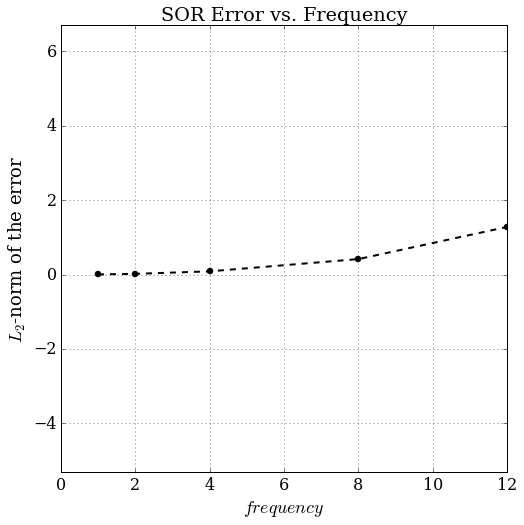

In [147]:
err_plot2(nf, err_freq_c2_g1, 'SOR Error vs. Frequency')
pyplot.savefig('err_an_c2_g1_nfreq.png')

#### let's look at a frequency of 8 and 12 again.

#### frequency = 8.0

In [149]:
#nf = 8.0
err_rel_c2_g2_w4,err_an_c2_g2_w4 = get_SOR_converge_c2(w_val,nxc[1],\
                                                    nyc[1],dx[1],dy[1],xc[1],yc[1],\
                                                    Xc[1],Yc[1], nf[3])

/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in double_scalars


In [150]:
err_rel_c2_g3_w4,err_an_c2_g3_w4 = get_SOR_converge_c2(w_val,nxc[2],\
                                                    nyc[2],dx[2],dy[2],xc[2],yc[2],\
                                                    Xc[2],Yc[2], nf[3])

/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in double_scalars


In [151]:
err_rel_c2_g4_w4,err_an_c2_g4_w4 = get_SOR_converge_c2(w_val,nxc[3],\
                                                    nyc[3],dx[3],dy[3],xc[3],yc[3],\
                                                    Xc[3],Yc[3], nf[3])

/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in double_scalars


In [152]:
err_rel_c2_g5_w4,err_an_c2_g5_w4 = get_SOR_converge_c2(w_val,nxc[4],\
                                                    nyc[4],dx[4],dy[4],xc[4],yc[4],\
                                                    Xc[4],Yc[4], nf[3])

/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in double_scalars


In [153]:
err_freq_c2_nfreq_w4 = [err_an_c2_g1_w4[0], err_an_c2_g2_w4[0], err_an_c2_g3_w4[0],\
                 err_an_c2_g4_w4[0], err_an_c2_g5_w4[0] ]

In [161]:
err_an_c2_g1_w4[0]

0.41767733079158464

In [162]:
 err_an_c2_g5_w4[0] 

0.0052804553816113769

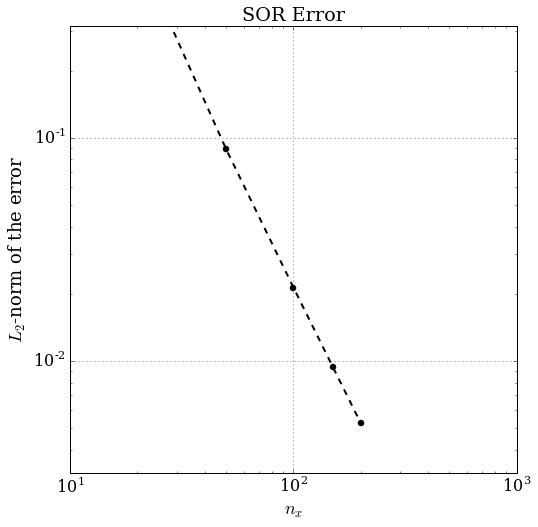

In [154]:
plot_error_grid_refine(err_freq_c2_nfreq_w4,nxc, 'SOR Error')
pyplot.savefig('errsor_c2_w4_nfreq.png')

#### frequency = 12

In [155]:
err_rel_c2_g2_w5,err_an_c2_g2_w5 = get_SOR_converge_c2(w_val,nxc[1],\
                                                    nyc[1],dx[1],dy[1],xc[1],yc[1],\
                                                    Xc[1],Yc[1], nf[4])

/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in double_scalars


In [156]:
err_rel_c2_g3_w5,err_an_c2_g3_w5 = get_SOR_converge_c2(w_val,nxc[2],\
                                                    nyc[2],dx[2],dy[2],xc[2],yc[2],\
                                                    Xc[2],Yc[2], nf[4])

/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in double_scalars


In [157]:
err_rel_c2_g4_w5,err_an_c2_g4_w5 = get_SOR_converge_c2(w_val,nxc[3],\
                                                    nyc[3],dx[3],dy[3],xc[3],yc[3],\
                                                    Xc[3],Yc[3], nf[4])

/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in double_scalars


In [158]:
err_rel_c2_g5_w5,err_an_c2_g5_w5 = get_SOR_converge_c2(w_val,nxc[4],\
                                                    nyc[4],dx[4],dy[4],xc[4],yc[4],\
                                                    Xc[4],Yc[4], nf[4])

/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in double_scalars


In [159]:
err_freq_c2_nfreq_w5 = [err_an_c2_g1_w5[0], err_an_c2_g2_w5[0], err_an_c2_g3_w5[0],\
                 err_an_c2_g4_w5[0], err_an_c2_g5_w5[0] ]

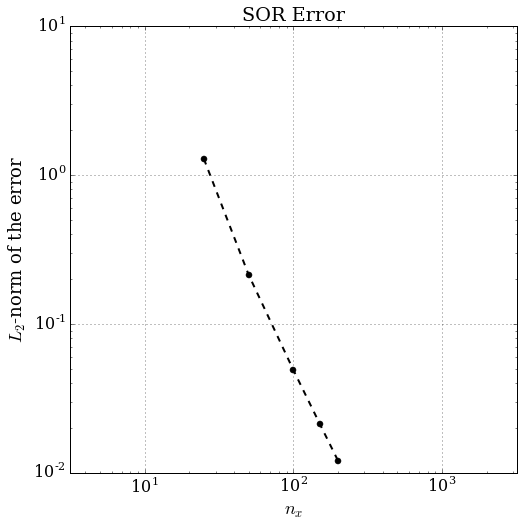

In [160]:
plot_error_grid_refine(err_freq_c2_nfreq_w5,nxc, 'SOR Error')
pyplot.savefig('errsor_c2_w5_nfreq.png')

In [163]:
err_an_c2_g1_w5[0]

1.2829577558772864

In [164]:
err_an_c2_g5_w5[0]

0.011928163217622407